# Import Library

In [1]:
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

# Import and Inspect Data Set 

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
#First 5 Row of Data 
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
#Check for Missing Data 
(df.isnull().sum()/len(df))*100

age                         0.0
anaemia                     0.0
creatinine_phosphokinase    0.0
diabetes                    0.0
ejection_fraction           0.0
high_blood_pressure         0.0
platelets                   0.0
serum_creatinine            0.0
serum_sodium                0.0
sex                         0.0
smoking                     0.0
time                        0.0
DEATH_EVENT                 0.0
dtype: float64

Conclusion : The Data Set is Clean and Ready for Model Building

In [5]:
#Check for Balanced Data 
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Conclusion : The target is unbalanced

In [6]:
#Data Set Info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


# Model Building

## Split Train Test Data

In [7]:
#Target and Feature selection 
X = df.drop('DEATH_EVENT', axis=1)
Y = df['DEATH_EVENT']

In [8]:
#Split Train Test Data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=df['DEATH_EVENT'], random_state=42)

## Baseline Model Building

In [9]:
#Use Random Forrest Classifier as Parameter
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

Text(0.5, 1.0, 'Confusion Matrix')

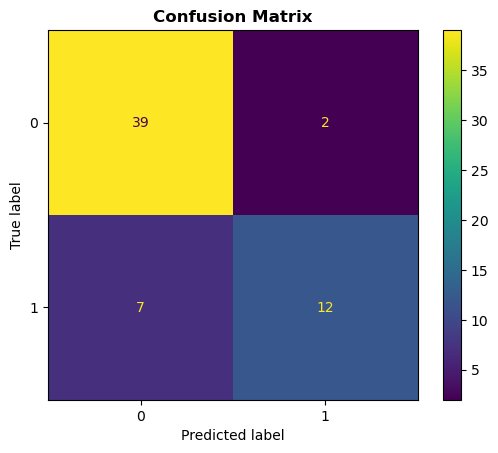

In [10]:
#Evaluation of Baseline Model 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.title('Confusion Matrix', fontweight = 'bold')

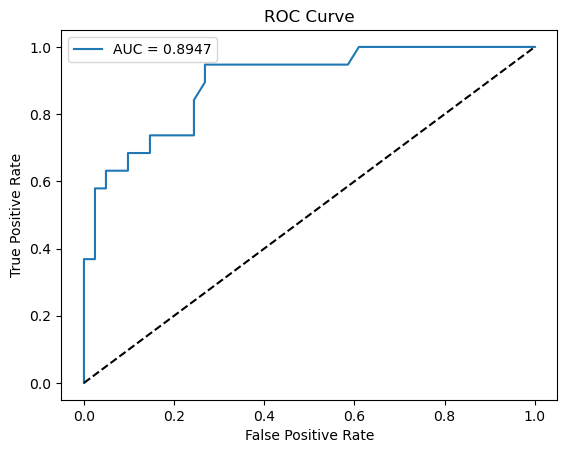

In [11]:
#Evaluation of AUC Score
#ROC AUC Curve Plot 
y_pred_proba = rf.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

In [12]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60



Conclusion: The model is sufficient enough, but we try to improve it and evaluate other ML Model

## Imbalanced Data Handling

In [13]:
#Perform SMOTE Imbalanced Data Handling 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_blncd, y_train_blncd = smote.fit_resample(X_train, y_train)

## Evaluate Other Machine Learning Algorithm

In [14]:
#Deploy Chosen Model 
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
model_alg = [rf, GradientBoostingClassifier(), AdaBoostClassifier() ]
df_mod_eval = pd.DataFrame(columns = ['Algorithm','AUC Score'])
for model in model_alg : 
    model.fit(X_train_blncd, y_train_blncd)
    algorithm = str(type(model)).split('.')[-1][:-2]
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    df_mod_eval = df_mod_eval.append({'Algorithm' : algorithm, 
                                    'AUC Score' : auc},ignore_index=True)
df_mod_eval

,Algorithm,AUC Score
0,RandomForestClassifier,0.793325
1,GradientBoostingClassifier,0.781130
2,AdaBoostClassifier,0.754814


In [15]:
#Evaluation for Gradient Boosting 
model_alg[1].fit(X_train_blncd,y_train_blncd)

GradientBoostingClassifier()

Text(0.5, 1.0, 'Confusion Matrix')

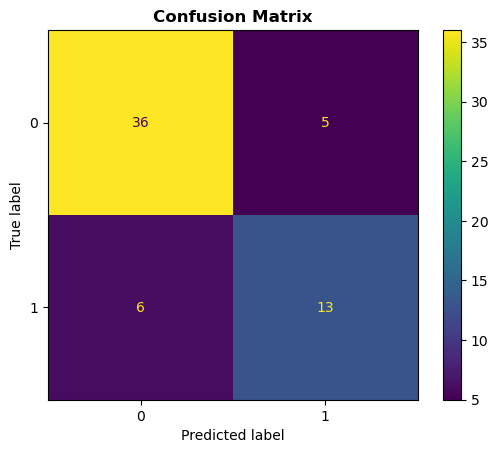

In [16]:
#Evaluation of Baseline Model 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, model_alg[1].predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.title('Confusion Matrix', fontweight = 'bold')

In [17]:
#Classification Report 
from sklearn.metrics import classification_report 
print(classification_report(y_test,model_alg[1].predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.72      0.68      0.70        19

    accuracy                           0.82        60
   macro avg       0.79      0.78      0.79        60
weighted avg       0.81      0.82      0.82        60



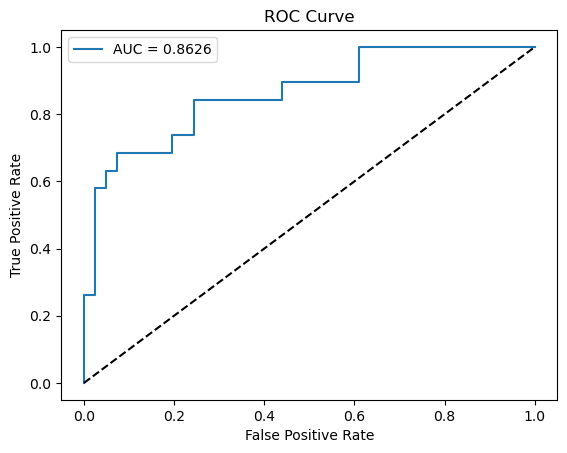

In [18]:
#AUC Score for Selected Algortihm 
#Evaluation of AUC Score
#ROC AUC Curve Plot 
y_pred_proba = model_alg[1].predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

Conclusion: This model will be used further since it has higher precision on Predicting Death Event (True Positive 14)

In [19]:
#Save Model for Deployment 
import pickle
pickle.dump(model_alg[1], open('Ensemble.pkl', 'wb'))